**Algerian Forest Fires - When Are You At Risk?**

**Introduction** 

A forest fire is the uncontrolled burning of plants in a natural setting such as a forest, that consumes natural fuels and spreads based on environmental conditions (“Forest Fires”, 2021). These fires can be caused by human actions, extreme drought, or lightning, and can have devastating effects on the environment and human life (“Forest Fires”, 2021). Some countries, such as Algeria, have higher instances of forest fires, as they have longer dry seasons and often lack the infrastructure to control such large fires (Meddour-Sahar, 2015). As such, predicting the onset of forest fires in these regions plays an integral role in the mitigation of this threat. 

For our project, we will predict when forest fires in Algeria will occur in the future, based on weather components. In particular, we want to know, “Under which weather conditions, considering relative humidity, temperature, wind speed and rain, are forest fires more likely to occur in the Bejaia region?” We will investigate this prediction by using the Algerian Forest Fires Dataset, which contains data from two regions of Algeria, but we will focus on the Bejaia region located in the northeast of the country. There are 11 total variables in this dataset, of which we will use 4, and there are 244 total observations. The period of data collection is from June of 2012 to September of 2012.

**Preliminary Exploratory Data Analysis**

In [193]:
#load libraries
library(readxl)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

In [194]:
download.file(url, destfile = "data/Algerian_forest_fires_dataset_UPDATE.csv")

In [195]:
#read data
bejaia_basic <- read_csv(file = "data/Algerian_forest_fires_dataset_UPDATE.csv", skip=1, n_max=122) %>%
mutate(Classes=as_factor(Classes))

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)



In [196]:
#tidy data
bejaia_with_date <- tidyr::unite(bejaia_basic, "Date", year, month, day, remove = FALSE,sep = "-" ) #combine year, month and day to make date
bejaia_tidy <- select(bejaia_with_date, Date, month, Temperature, RH, Ws, Rain, Classes) #select only variables we will be using

In [197]:
#create the train/test split
bejaia_split <- initial_split(bejaia_tidy, prop=0.75, strata=Classes)
bejaia_train <- training(bejaia_split)
bejaia_test <- training (bejaia_split)
glimpse(bejaia_train)

Rows: 93
Columns: 7
$ Date        <chr> "2012-06-01", "2012-06-02", "2012-06-04", "2012-06-05", "…
$ month       <chr> "06", "06", "06", "06", "06", "06", "06", "06", "06", "06…
$ Temperature <dbl> 29, 29, 25, 27, 31, 33, 30, 28, 31, 26, 27, 30, 29, 30, 3…
$ RH          <dbl> 57, 61, 89, 77, 67, 54, 73, 79, 65, 81, 84, 78, 89, 89, 5…
$ Ws          <dbl> 18, 13, 13, 16, 14, 13, 15, 12, 14, 19, 21, 20, 13, 16, 1…
$ Rain        <dbl> 0.0, 1.3, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.…
$ Classes     <fct> not fire, not fire, not fire, not fire, fire, fire, fire,…


In [198]:
#summarize training data in a table
num_obs <- nrow(bejaia_train)
bejaia_train %>% group_by(Classes) %>% summarize(n=n(), percentage = n()/num_obs*100)

`summarise()` ungrouping output (override with `.groups` argument)



Classes,n,percentage
<fct>,<int>,<dbl>
not fire,48,51.6129
fire,45,48.3871


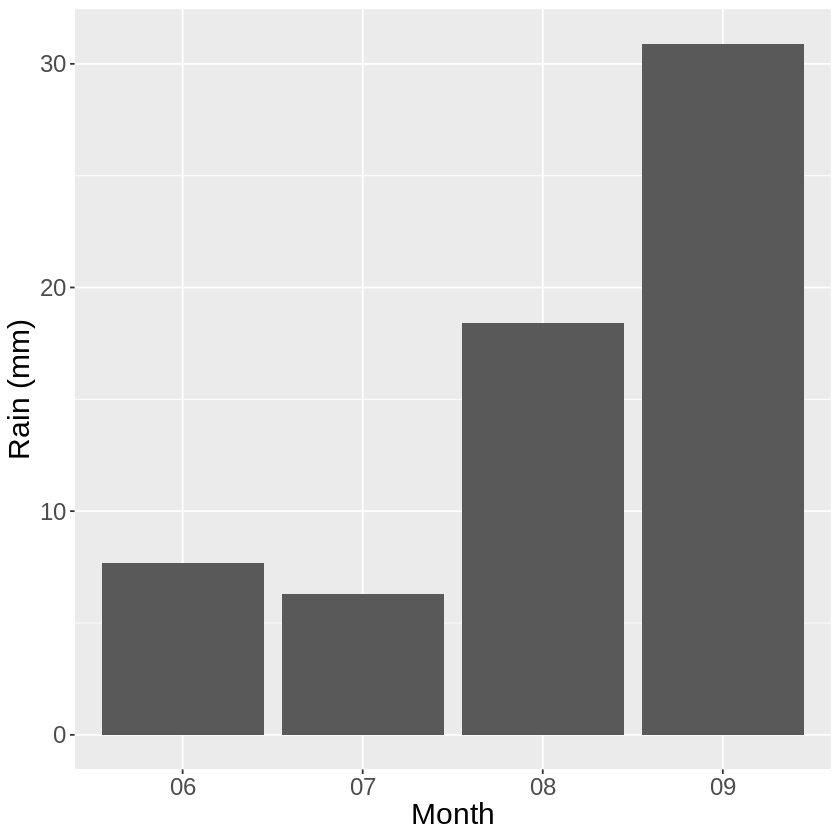

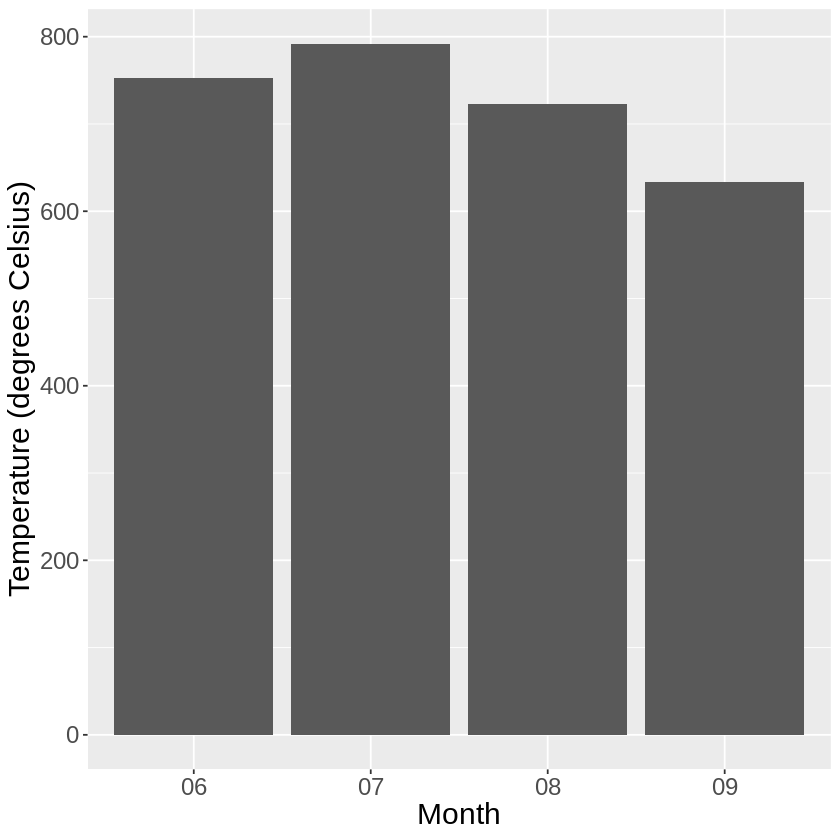

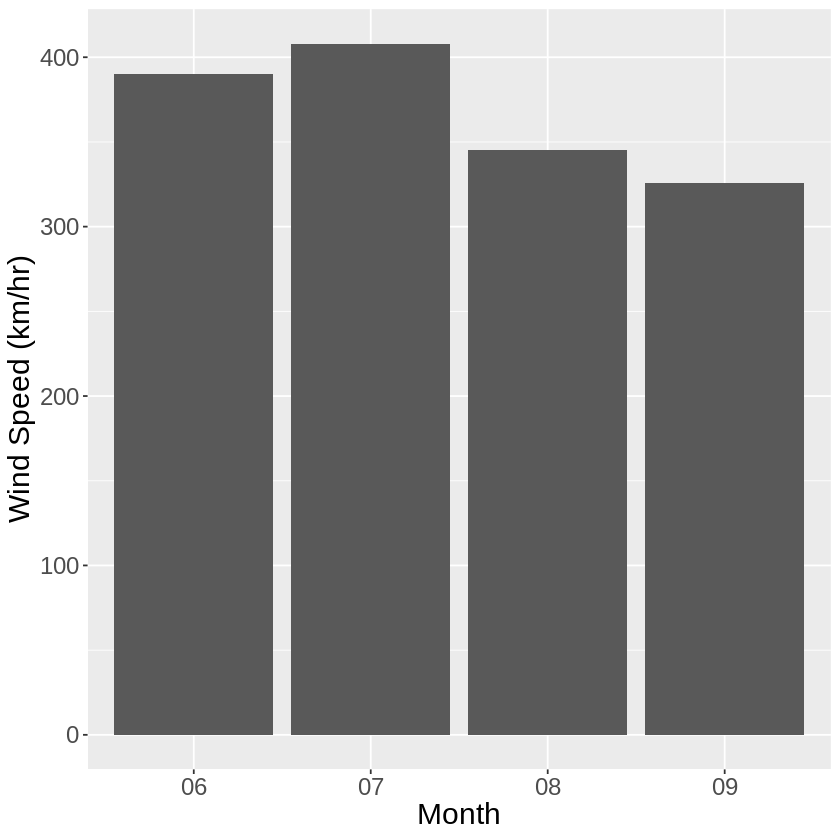

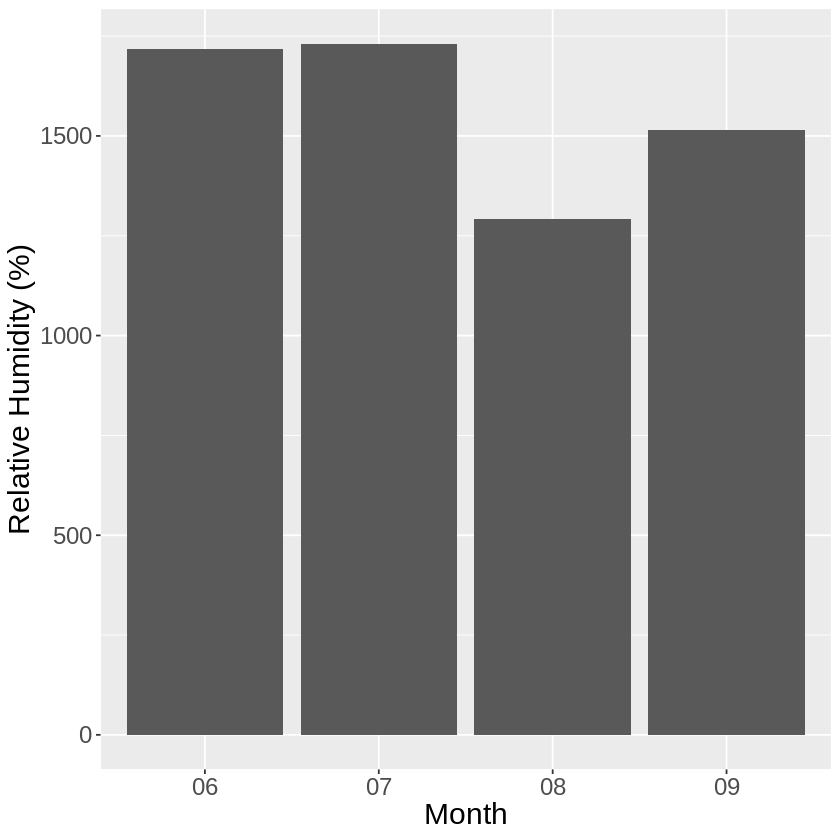

In [203]:
#use training data to make a visualization comparing distributions of predictor variables

bejaia_graph_1 <- ggplot(bejaia_train, aes(x=month, y=Rain))+
geom_bar(stat = "identity")+
xlab("Month")+
ylab("Rain (mm)")+
theme(text = element_text(size = 18))
bejaia_graph_1

bejaia_graph_2 <- ggplot(bejaia_train, aes(x=month, y=Temperature))+
geom_bar(stat = "identity")+
xlab("Month")+
ylab("Temperature (degrees Celsius)")+
theme(text = element_text(size = 18))
bejaia_graph_2

bejaia_graph_3 <- ggplot(bejaia_train, aes(x=month, y=Ws))+
geom_bar(stat = "identity")+
xlab("Month")+
ylab("Wind Speed (km/hr)")+
theme(text = element_text(size = 18))
bejaia_graph_3

bejaia_graph_4 <- ggplot(bejaia_train, aes(x=month, y=RH))+
geom_bar(stat = "identity")+
xlab("Month")+
ylab("Relative Humidity (%)")+
theme(text = element_text(size = 18))
bejaia_graph_4

**Methods**

For our data analysis, we will use weather data observations, including the variables Relative Humidity (RH), Temperature, Wind Speed (WS), and Rain to predict when forest fires are more likely to occur in the Bejaia region. We omitted the variables from the FWI components, which are derived from the weather data observations. To answer our question, we will use these variables to perform classification and predict when forest fires are more likely to occur. 


**Expected Outcomes and Signficance**

We hope to predict when forest fires are more likely to occur by observing weather conditions. We expect that forest fires will be more likely at lower relative humidity, higher temperatures, higher wind speeds, and less rain. 

These findings could help residents recognize forest fire conditions, which could result in less damage to property and fewer casualties. For example, during high-risk conditions, civilians may prepare for forest fires by creating emergency kits in case of evacuation, or farmers may trim lawns and tall vegetation to minimize damage (Weir, 2018). 

This data could lead to future questions, such as how the likelihood of forest fires differs between regions of Algeria. Taking data from other regions could help us better understand how climate conditions differ across Algeria, and how this variation in conditions affects the likelihood of forest fires. 
